In [38]:
# std
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# img viz
import matplotlib.pyplot as plt
import seaborn as sns

# img proc
import cv2
from skimage import color, io
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.feature import daisy

# ml
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# tensorflow
import tensorflow as tf

# torch
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [3]:
class PlantDataset(Dataset):
  """Load images as needed. Directory must be placed as: datadir/split/category/*.png"""
  def __init__(self,
                datadir='/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/final_dataset',
                split='train',
                fmt='np'):
      # store image list from disk
      self.im_paths = sorted(glob.glob(os.path.join(datadir, split, '**/*.png')))
      # store the labels and create lookup for easy retrieval
      self.lbl_list = list(map(lambda lbl: lbl.split(os.path.sep)[-2].lower(), self.im_paths))
      self.lbl_cat_lkp = {e: i for i, e in enumerate(sorted(list(set(self.lbl_list))))}
      self.cat_lbl_lkp = {i: e for e, i in self.lbl_cat_lkp.items()}
      self.cat = np.array([self.lbl_cat_lkp[e] for e in self.lbl_list])
      self.fmt=fmt
      self.split=split

  def get_impath(self, idx): return self.im_paths[idx]

  def __getitem__(self, idx):
      """Return processed image from file list"""
      if self.fmt=='torch':
          im_path = self.im_paths[idx]
          tim = read_image(im_path, ImageReadMode.RGB)
          return tim/255, self.cat[idx]
      elif self.fmt=='np':
          im_path = self.im_paths[idx]
          npim = plt.imread(im_path)[..., :3] # remove alpha channel
          return npim, self.cat[idx]

  def __len__(self): return len(self.im_paths)

train_dset = PlantDataset()
print(f'>> Images on {train_dset.split}: {len(train_dset):,}')
print(pd.Series(train_dset.lbl_list).value_counts())

val_dset = PlantDataset(split='validation')
print(f'\n>> Images on {val_dset.split}: {len(val_dset):,}')
print(pd.Series(val_dset.lbl_list).value_counts())

test_dset = PlantDataset(split='test')
print(f'\n>> Images on {test_dset.split}: {len(test_dset):,}')
print(pd.Series(test_dset.lbl_list).value_counts())

print(f'\n>> Total images: {len(test_dset) + len(val_dset) + len(train_dset):,}')

>> Images on train: 14,523
tomato_yellow_leaf_curl_virus           4285
bacterial_spot                          1701
late_blight                             1527
septoria_leaf_spot                      1416
spider_mites_two-spotted_spider_mite    1340
healthy                                 1272
target_spot                             1123
early_blight                             800
leaf_mold                                761
tomato_mosaic_virus                      298
dtype: int64

>> Images on validation: 1,812
tomato_yellow_leaf_curl_virus           535
bacterial_spot                          212
late_blight                             190
septoria_leaf_spot                      177
spider_mites_two-spotted_spider_mite    167
healthy                                 159
target_spot                             140
early_blight                            100
leaf_mold                                95
tomato_mosaic_virus                      37
dtype: int64

>> Images on test: 1,824

# Features

Create CSV files with the features to be able to read them quickly and easily. CSVs are on a shared Google drive.

In [5]:
def read_features_from_files(file_list):
  feats = [pd.read_csv(f).values for f in file_list]
  return np.concatenate(feats, axis=1).astype(np.float32)

## Color histogram

In [ ]:
from tqdm import tqdm

def rgb_hist(img, bins=50, rng=(0, 256), get_edges=False):
  norm = img.shape[0] * img.shape[1]
  rhist, rhist_edges = np.histogram(img[:, :, 0], bins=bins, range=rng)
  ghist, ghist_edges = np.histogram(img[:, :, 1], bins=bins, range=rng)
  bhist, bhist_edges = np.histogram(img[:, :, 2], bins=bins, range=rng)
  hist_concat = np.concatenate([rhist/norm, ghist/norm, bhist/norm])
  if get_edges:
    return hist_concat, rhist_edges
  return hist_concat


def calc_rgb_hists(dataset, bins=50, rng=(0, 256), density=False, get_edges=False):
    """Histogram for each RGB channel for a given image. Returns R,G,B histograms concatenated (1 vector per image on dataset)"""
    hist_list = []
    norm = 256*256
    for img, _ in tqdm(dataset):
        rhist, rhist_edges = np.histogram(img[:, :, 0], bins=bins, range=rng, density=density)
        ghist, ghist_edges = np.histogram(img[:, :, 1], bins=bins, range=rng, density=density)
        bhist, bhist_edges = np.histogram(img[:, :, 2], bins=bins, range=rng, density=density)
        hist_list.append(np.concatenate([rhist/norm, ghist/norm, bhist/norm]))
    if get_edges:
        return np.stack(hist_list), rhist_edges
    return np.stack(hist_list)


def calc_lab_hist(dataset, bins=50, density=False):
    """Histogram for each L*a*b channel for a given image. Range of histograms is defined based on possible values of each channel. Returns L,a,b histograms concatenated (1 vector per image on dataset)"""
    hist_list = []
    norm = 256*256
    for img, _ in tqdm(dataset):
        img_lab = color.rgb2lab(img)
        lhist, rhist_edges = np.histogram(img_lab[:, :, 0], bins=bins, range=(0, 100), density=density)
        ahist, ghist_edges = np.histogram(img_lab[:, :, 1], bins=bins, range=(-86, 98), density=density)
        bhist, bhist_edges = np.histogram(img_lab[:, :, 2], bins=bins, range=(-107, 94), density=density)
        hist_list.append(np.concatenate([lhist/norm, ahist/norm, bhist/norm]))
    return np.stack(hist_list)

### RGB

Have a histogram for each primary color. The number of bins is a hyperparameter that will increase/decrease the dimensionality of the dataset.

There are a lot of 0s on the dataset given the black background. Need to decide if we want to remove that bin for the classification.

In [ ]:
# takes about 2.5mins to run for the whole dataset: bins=100, range(0, 1)
nbins=150
print('Train')
rgb_hists = calc_rgb_hists(train_dset, bins=nbins, rng=(0, 1))
print(rgb_hists.shape)
pd.DataFrame(rgb_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_rgbhist_b150_r0-1_prob.csv', index=False)

print('Validation')
rgb_hists = calc_rgb_hists(val_dset, bins=nbins, rng=(0, 1))
print(rgb_hists.shape)
pd.DataFrame(rgb_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_rgbhist_b150_r0-1_prob.csv', index=False)

print('Test')
rgb_hists = calc_rgb_hists(test_dset, bins=nbins, rng=(0, 1))
print(rgb_hists.shape)
pd.DataFrame(rgb_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_rgbhist_b150_r0-1_prob.csv', index=False)

Train


100%|██████████| 14523/14523 [01:42<00:00, 141.63it/s]


(14523, 450)
Validation


100%|██████████| 1812/1812 [00:12<00:00, 140.61it/s]


(1812, 450)
Test


100%|██████████| 1824/1824 [00:12<00:00, 144.40it/s]


(1824, 450)


Aggregated histograms for all classes

In [9]:
### read data on CSVs
# train
X_rgbhist_train = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_rgbhist_b100_r0-1_prob.csv'
])
Y_train = train_dset.cat
print('Train:', X_rgbhist_train.shape, Y_train.shape)

# val
X_rgbhist_val = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_rgbhist_b100_r0-1_prob.csv'
])
Y_val = val_dset.cat
print('Validation:', X_rgbhist_val.shape, Y_val.shape)

# test
X_rgbhist_test = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_rgbhist_b100_r0-1_prob.csv'
])
Y_test = test_dset.cat
print('Test:', X_rgbhist_test.shape, Y_test.shape)

Train: (14523, 300) (14523,)
Validation: (1812, 300) (1812,)
Test: (1824, 300) (1824,)


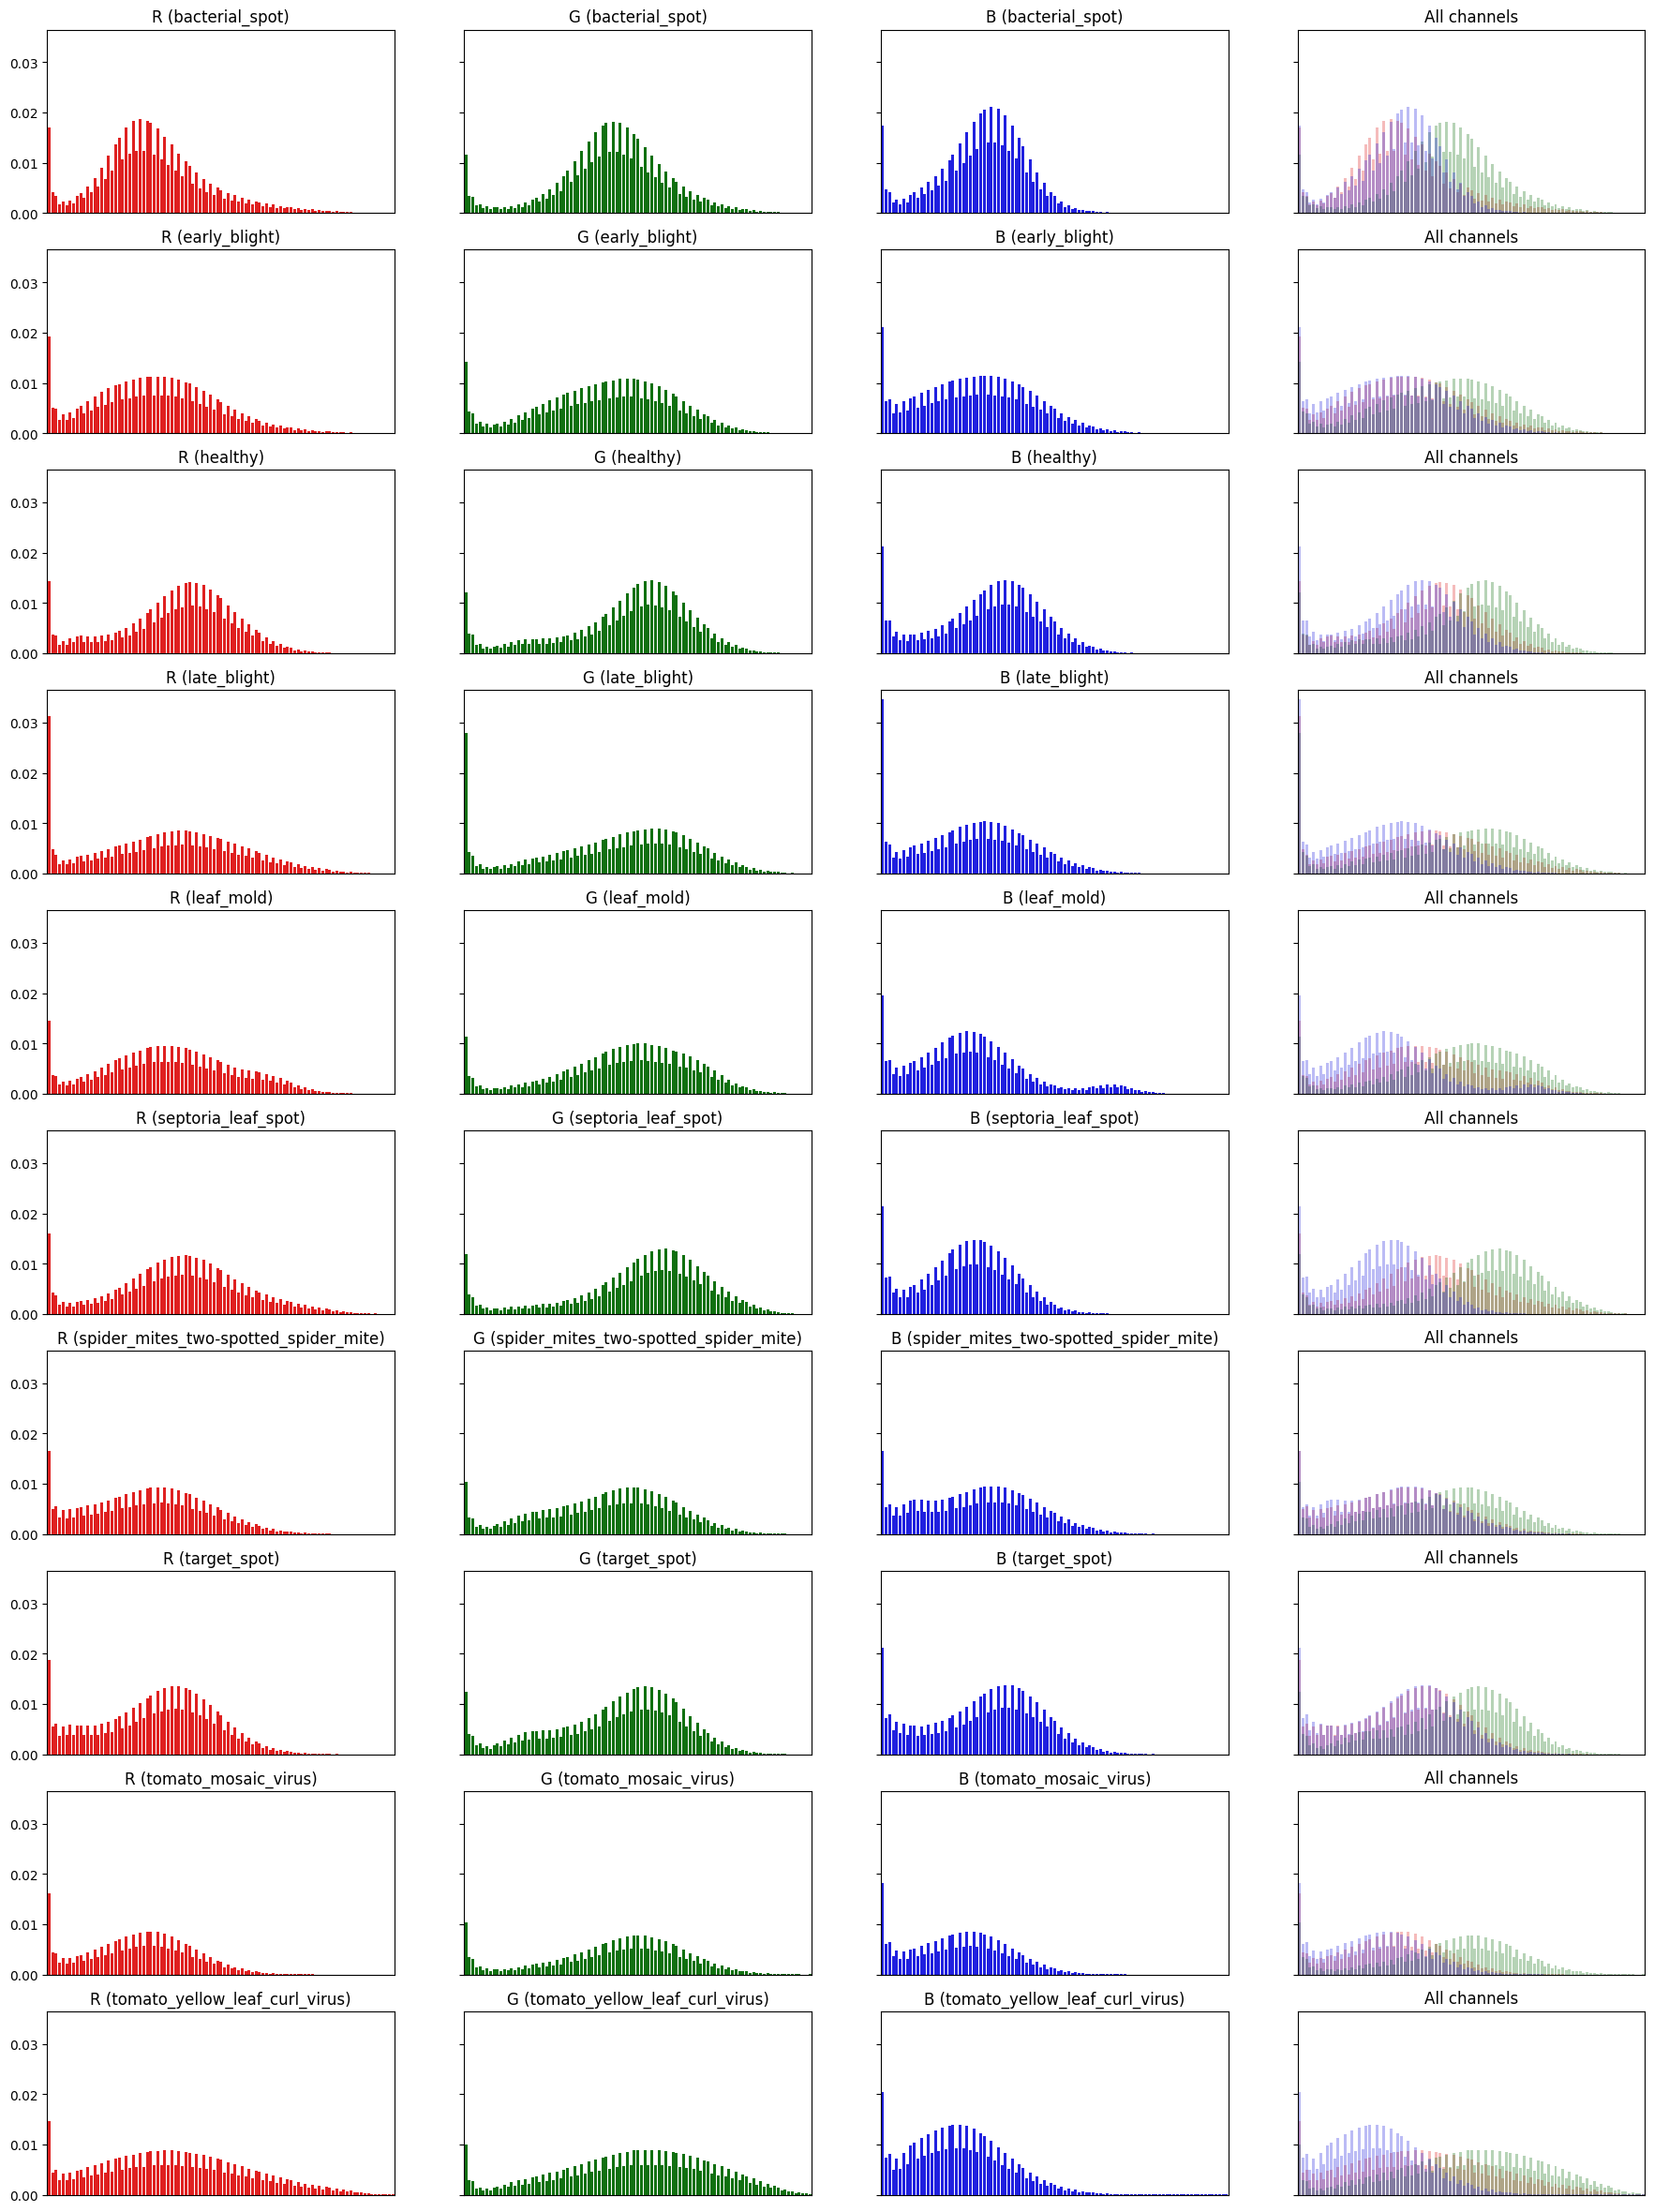

In [16]:
### plot the histograms
n_cat = 10
fig, ax = plt.subplots(n_cat, 4, sharey=True, figsize=(22, n_cat*3))
for cat in range(n_cat):
    # get the histograms
    r_hist0 = X_rgbhist_train[Y_train==cat].mean(axis=0)[1:100]
    g_hist0 = X_rgbhist_train[Y_train==cat].mean(axis=0)[101:200]
    b_hist0 = X_rgbhist_train[Y_train==cat].mean(axis=0)[201:]
    ax[cat, 0].set_title(f'R ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 0].xaxis.set_visible(False)
    # ax[cat, 0].set_ylim((0, 5e6))
    ax[cat, 1].set_title(f'G ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 1].xaxis.set_visible(False)
    # ax[cat, 1].set_ylim((0, 5e6))
    ax[cat, 2].set_title(f'B ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 2].xaxis.set_visible(False)
    # ax[cat, 2].set_ylim((0, 5e6))
    sns.barplot(x=np.arange(99), y=r_hist0, color='red', ax=ax[cat, 0])
    sns.barplot(x=np.arange(99), y=g_hist0, color='green', ax=ax[cat, 1])
    sns.barplot(x=np.arange(99), y=b_hist0, color='blue', ax=ax[cat, 2])

    ax[cat, 3].set_title(f'All channels')
    ax[cat, 3].xaxis.set_visible(False)
    sns.barplot(x=np.arange(99), y=r_hist0, color='red', alpha=0.3, ax=ax[cat, 3])
    sns.barplot(x=np.arange(99), y=g_hist0, color='green', alpha=0.3, ax=ax[cat, 3])
    sns.barplot(x=np.arange(99), y=b_hist0, color='blue', alpha=0.3, ax=ax[cat, 3])

#### PCA

In [23]:
nc = 25
pca = PCA(n_components=nc)
X_train_pca = pca.fit_transform(X_rgbhist_train)

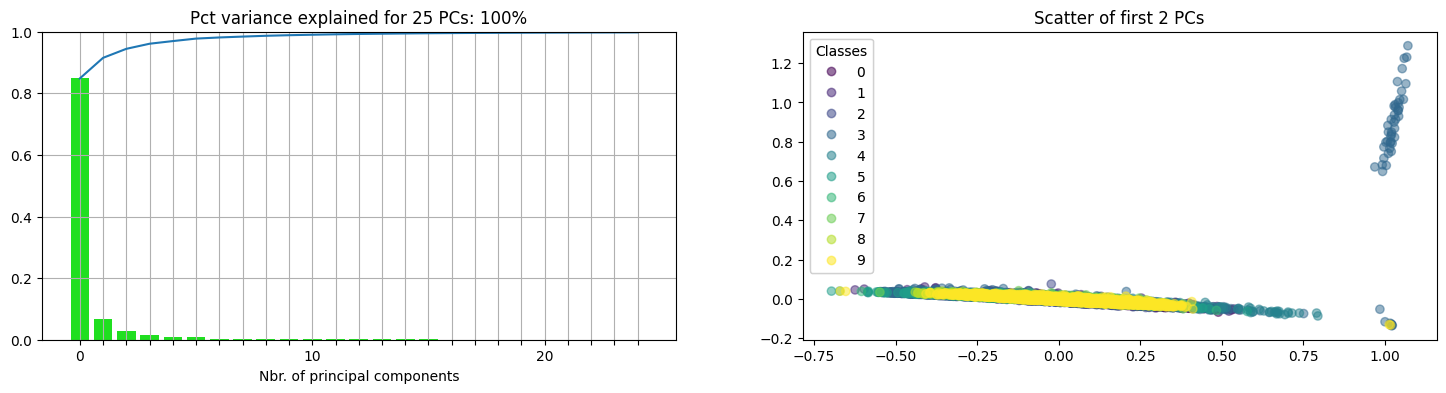

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# variance ratio % per PC
bar = sns.barplot(x=np.arange(nc), y=pca.explained_variance_ratio_, color='lime', ax=ax[0])
for ind, label in enumerate(bar.get_xticklabels()):
  if ind % 10 == 0:  # every 10th label is kept
      label.set_visible(True)
  else:
      label.set_visible(False)
sns.lineplot(x=np.arange(nc), y=np.cumsum(pca.explained_variance_ratio_), ax=ax[0])
ax[0].set_title(f'Pct variance explained for {nc} PCs: {pca.explained_variance_ratio_.sum():.0%}')
ax[0].set_xlabel('Nbr. of principal components')
ax[0].set_ylim([0, 1.])

# scatter of 2 PCs
scatter = ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, alpha=0.5)
legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].add_artist(legend1)
ax[1].set_title('Scatter of first 2 PCs')

plt.show()

### L\*a\*b

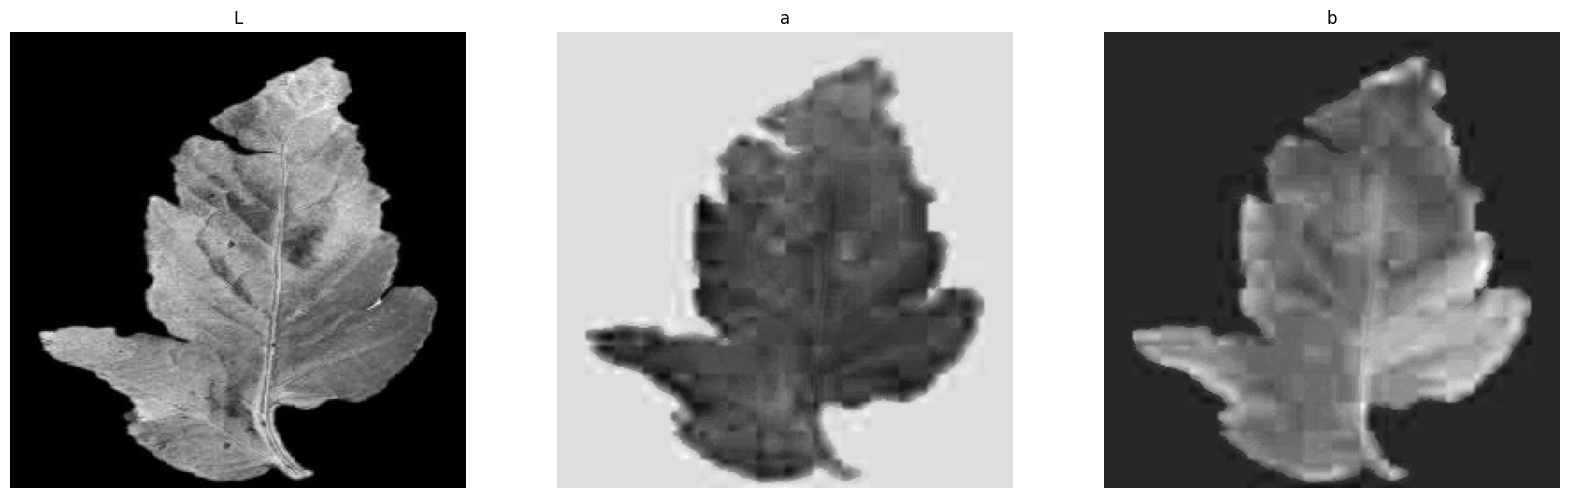

In [28]:
img, lbl = train_dset[0]
img_lab = color.rgb2lab(img)

# plot channels
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_lab[:, :, 0], cmap='gray')
ax[0].set_title('L')
ax[0].axis('off')
ax[1].imshow(img_lab[:, :, 1], cmap='gray')
ax[1].set_title('a')
ax[1].axis('off')
ax[2].imshow(img_lab[:, :, 2], cmap='gray')
ax[2].set_title('b')
ax[2].axis('off')
plt.show()

In [ ]:
# takes about 5mins to run for the whole dataset
nbins=150
print('Train')
lab_hists = calc_lab_hist(train_dset, bins=nbins)
print(lab_hists.shape)
pd.DataFrame(lab_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_labhist_b150_prob.csv', index=False)

print('Validation')
lab_hists = calc_lab_hist(val_dset, bins=nbins)
print(lab_hists.shape)
pd.DataFrame(lab_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_labhist_b150_prob.csv', index=False)

print('Test')
lab_hists = calc_lab_hist(test_dset, bins=nbins)
print(lab_hists.shape)
pd.DataFrame(lab_hists).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_labhist_b150_prob.csv', index=False)

Train


100%|██████████| 14523/14523 [03:11<00:00, 75.64it/s]


(14523, 450)
Validation


100%|██████████| 1812/1812 [00:24<00:00, 75.40it/s]


(1812, 450)
Test


100%|██████████| 1824/1824 [00:24<00:00, 75.86it/s]


(1824, 450)


Aggregated histograms for all classes

In [31]:
# train
X_labhist_train = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_labhist_b100_prob.csv'
])
Y_train = train_dset.cat
print('Train:', X_labhist_train.shape)

# val
X_labhist_val = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_labhist_b100_prob.csv'
])
Y_val = val_dset.cat
print('Validation:', X_labhist_val.shape)

# test
X_labhist_test = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_labhist_b100_prob.csv'
])
Y_test = test_dset.cat
print('Test:', X_labhist_test.shape)

Train: (14523, 300)
Validation: (1812, 300)
Test: (1824, 300)


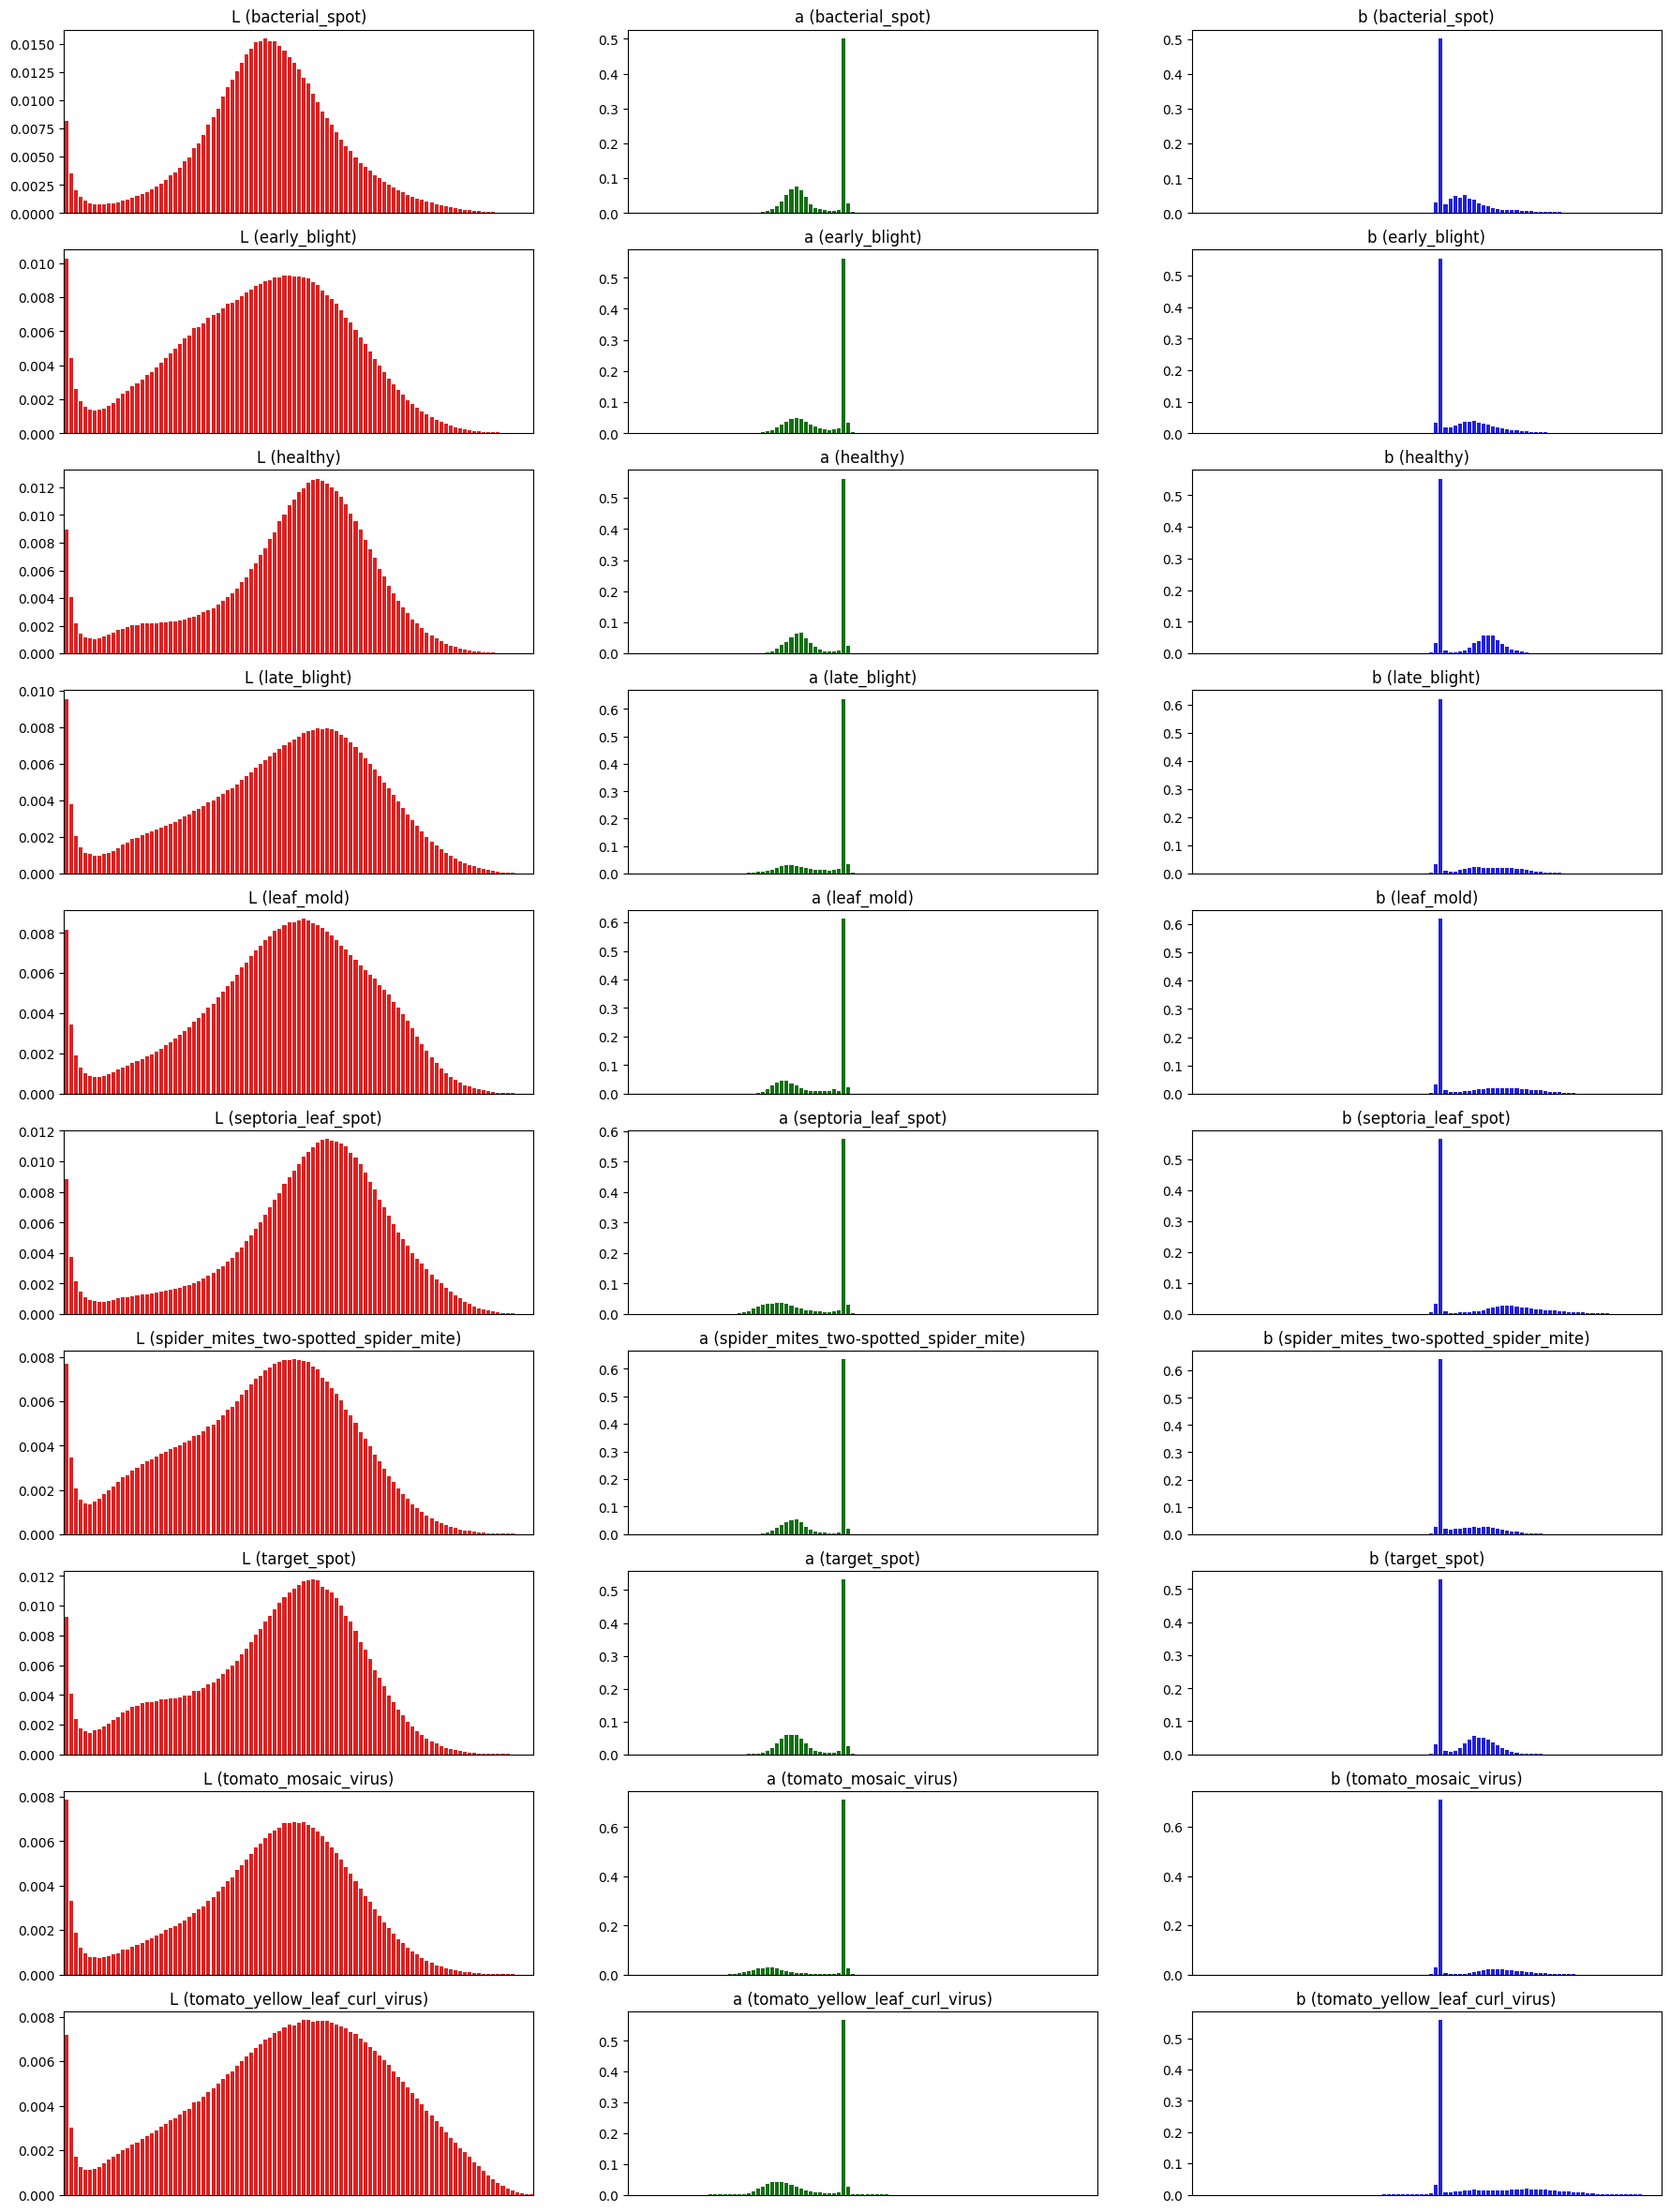

In [32]:
n_cat = 10
fig, ax = plt.subplots(n_cat, 3, figsize=(22, n_cat*3))
for cat in range(n_cat):
    # get the histograms
    r_hist0 = X_labhist_train[Y_train==cat].mean(axis=0)[1:100]
    g_hist0 = X_labhist_train[Y_train==cat].mean(axis=0)[101:200]
    b_hist0 = X_labhist_train[Y_train==cat].mean(axis=0)[201:]
    ax[cat, 0].set_title(f'L ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 0].xaxis.set_visible(False)
#     ax[cat, 0].set_ylim((0, 5e6))
    ax[cat, 1].set_title(f'a ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 1].xaxis.set_visible(False)
#     ax[cat, 1].set_ylim((0, 5e6))
    ax[cat, 2].set_title(f'b ({train_dset.cat_lbl_lkp[cat]})')
    ax[cat, 2].xaxis.set_visible(False)
#     ax[cat, 2].set_ylim((0, 5e6))
    sns.barplot(x=np.arange(99), y=r_hist0, color='red', ax=ax[cat, 0])
    sns.barplot(x=np.arange(99), y=g_hist0, color='green', ax=ax[cat, 1])
    sns.barplot(x=np.arange(99), y=b_hist0, color='blue', ax=ax[cat, 2])

#### PCA

In [52]:
nc = 25
pca = PCA(n_components=nc)
X_train_pca = pca.fit_transform(X_labhist_train)

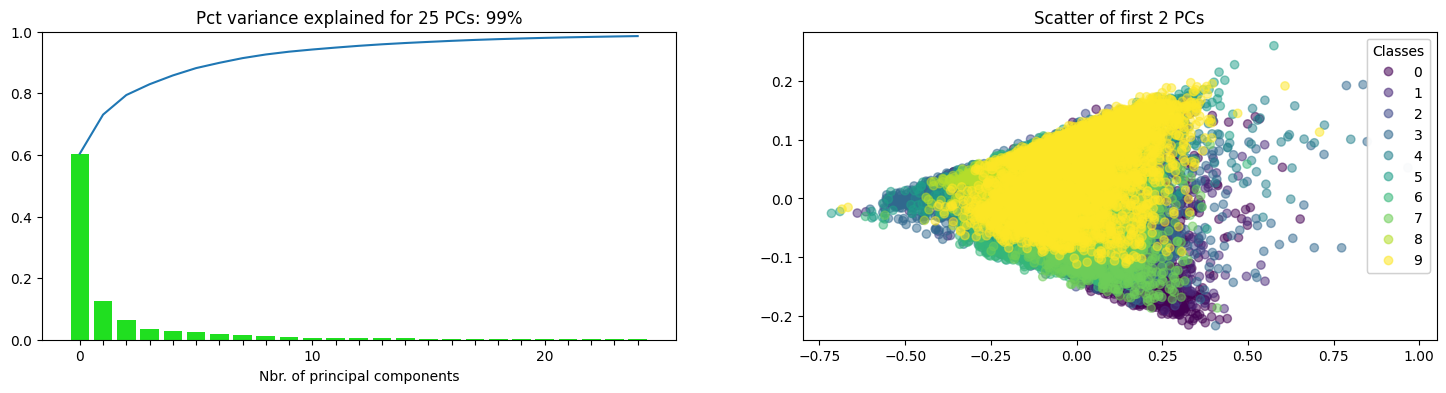

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# variance ratio % per PC
bar = sns.barplot(x=np.arange(nc), y=pca.explained_variance_ratio_, color='lime', ax=ax[0])
for ind, label in enumerate(bar.get_xticklabels()):
  if ind % 10 == 0:  # every 10th label is kept
      label.set_visible(True)
  else:
      label.set_visible(False)
sns.lineplot(x=np.arange(nc), y=np.cumsum(pca.explained_variance_ratio_), ax=ax[0])
ax[0].set_title(f'Pct variance explained for {nc} PCs: {pca.explained_variance_ratio_.sum():.0%}')
ax[0].set_xlabel('Nbr. of principal components')
ax[0].set_ylim([0, 1.])
# ax.grid()

# scatter of 2 PCs
scatter = ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, alpha=0.5)
legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].add_artist(legend1)
ax[1].set_title('Scatter of first 2 PCs')

plt.show()

### Blob detection

In [ ]:
train_dset.cat_lbl_lkp

{0: 'bacterial_spot',
 1: 'early_blight',
 2: 'healthy',
 3: 'late_blight',
 4: 'leaf_mold',
 5: 'septoria_leaf_spot',
 6: 'spider_mites_two-spotted_spider_mite',
 7: 'target_spot',
 8: 'tomato_mosaic_virus',
 9: 'tomato_yellow_leaf_curl_virus'}

N blobs: 662


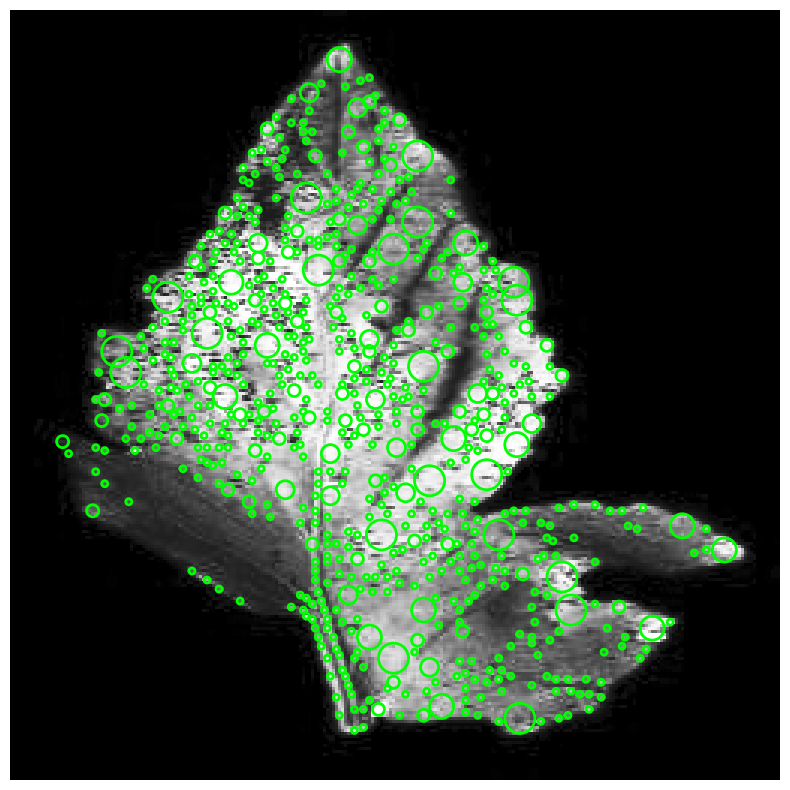

In [ ]:
# use spot image to test
spot_idx = np.where(train_dset.cat==2)[0][220]
spot_img = train_dset[spot_idx][0]
spot_img_gray = rgb2gray(spot_img)
spot_img_gray = exposure.equalize_hist(spot_img_gray)
blobs_log = blob_log(spot_img_gray, min_sigma=1, max_sigma=5, num_sigma=5, threshold=.025)
print('N blobs:', blobs_log.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(spot_img_gray, cmap='gray')
ax.set_axis_off()
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    ax.add_patch(c)

N blobs: 1003


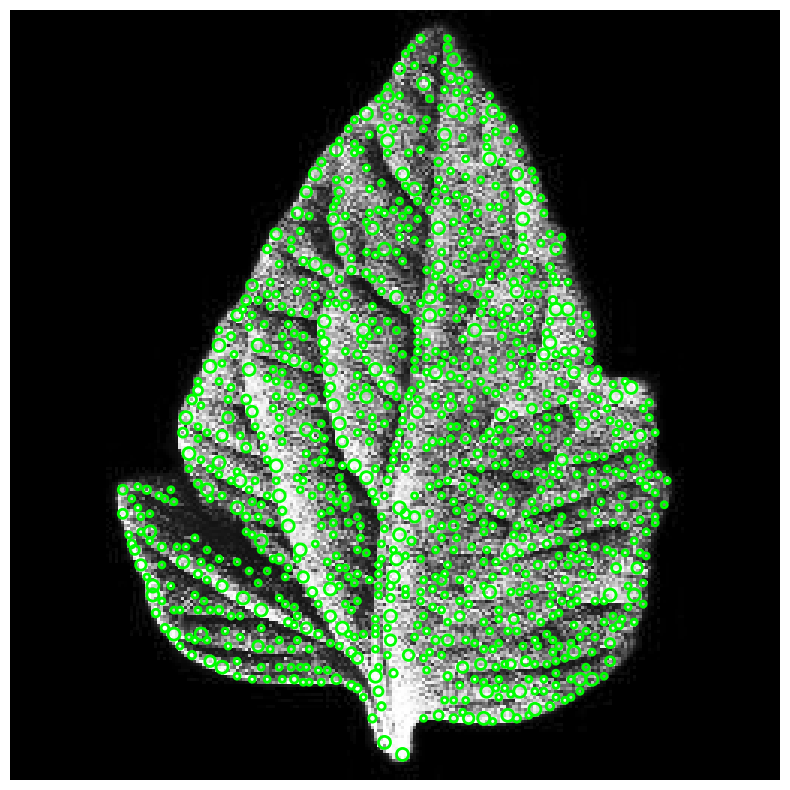

In [ ]:
# healthy image to compare
healthy_img_gray = rgb2gray(healthy_img)
healthy_img_gray = exposure.equalize_hist(healthy_img_gray)
blobs_log = blob_log(healthy_img_gray, min_sigma=1, max_sigma=2, num_sigma=5, threshold=.05)
print('N blobs:', blobs_log.shape[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(healthy_img_gray, cmap='gray')
ax.set_axis_off()
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=2, fill=False)
    ax.add_patch(c)

Blob detection is very sensitive to light variations and ends up capturing a lot of noise.

### Canny (edge detection)

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import canny

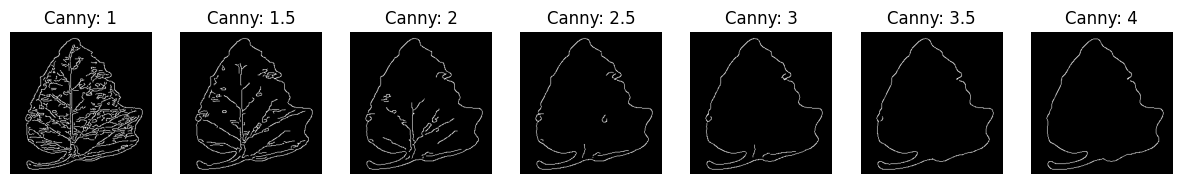

In [ ]:
healthy_idx = np.where(train_dset.cat==0)[0][0]
healthy_img = train_dset[healthy_idx][0]
healthy_img_gray = rgb2gray(healthy_img)

fig, ax = plt.subplots(1, 7, figsize=(15, 15))
for i,s in enumerate([1, 1.5, 2, 2.5, 3, 3.5, 4]):
    img_canny = canny(healthy_img_gray, sigma=s)
    ax[i].imshow(img_canny, cmap='gray')
    ax[i].set_title(f'Canny: {s}')
    ax[i].axis('off')

### DAISY

Try different DAISY parameters

DAISY shape: (3, 3, 104)


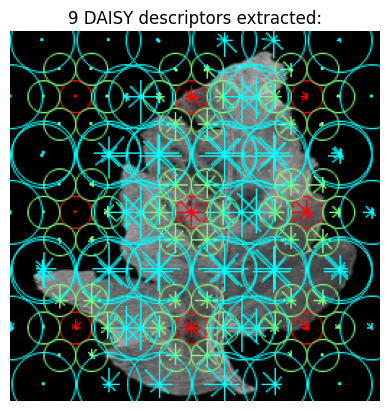

In [41]:
# select an image
healthy_idx = np.where(train_dset.cat==0)[0][0]
healthy_img = train_dset[healthy_idx][0]
healthy_img_gray = rgb2gray(healthy_img)

# choose parameters
step=80
radius=45
rings=2
histograms=6
orientations=8
descs, descs_img = daisy(healthy_img_gray, step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=True)
print('DAISY shape:', descs.shape)

# plot
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title(f"{descs_num} DAISY descriptors extracted:")
plt.show()

DAISY shape (4, 4, 152)


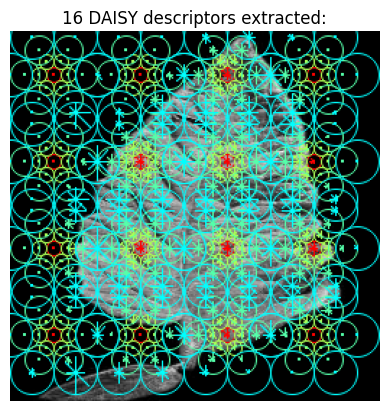

In [46]:
# select an image
spot_idx = np.where(train_dset.cat==2)[0][220]
spot_img = train_dset[spot_idx][0]
spot_img_gray = rgb2gray(spot_img)

# select parameters
step=60
radius=30
rings=3
histograms=6
orientations=8

descs, descs_img = daisy(
    spot_img_gray,
    step=step,
    radius=radius,
    rings=rings,
    histograms=histograms,
    orientations=orientations,
    visualize=True)
print('DAISY shape', descs.shape)

# plot
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title(f"{descs_num} DAISY descriptors extracted:")
plt.show()

In [ ]:
import time

def get_daisy_features(dataset, **daisy_kwargs):
    """Calculate the DAISY descriptor an return each u,v location histograms concatenated (1 vector per image on dataset)"""
    daisy_descs = []
    count = 0
    try:
      for img, _ in tqdm(dataset):
          img_gray = rgb2gray(img)
          daisy_desc = daisy(img_gray, **daisy_kwargs)
          daisy_descs.append(daisy_desc.ravel())
      return np.array(daisy_descs)
    except Exception as e:
      print(str(e))

# takes 60mins to run for whole dataset
step = 80
r = 45
rings = 2
hists = 6
orientations = 8

start_time = time.time()
daisy_feats = get_daisy_features(train_dset, step=step, radius=r, rings=rings, histograms=hists, orientations=orientations)
print(f'Train Took {time.time() - start_time}s to run')
print(daisy_feats.shape)
pd.DataFrame(daisy_feats).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_daisy_s80_rad45_rings2_h6_o8.csv', index=False)

100%|██████████| 14523/14523 [1:43:45<00:00,  2.33it/s]


Train Took 6225.513614654541s to run
(14523, 936)


In [ ]:
start_time = time.time()
daisy_feats = get_daisy_features(val_dset, step=step, radius=r, rings=rings, histograms=hists, orientations=orientations)
print(f'Validation Took {time.time() - start_time}s to run')
print(daisy_feats.shape)
pd.DataFrame(daisy_feats).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_daisy_s80_rad45_rings2_h6_o8.csv', index=False)


start_time = time.time()
daisy_feats = get_daisy_features(test_dset, step=step, radius=r, rings=rings, histograms=hists, orientations=orientations)
print(f'Test Took {time.time() - start_time}s to run')
print(daisy_feats.shape)
pd.DataFrame(daisy_feats).to_csv('/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_daisy_s80_rad45_rings2_h6_o8.csv', index=False)

100%|██████████| 1812/1812 [12:57<00:00,  2.33it/s]


Validation Took 777.8771390914917s to run
(1812, 936)


100%|██████████| 1824/1824 [13:27<00:00,  2.26it/s]


Test Took 807.4134650230408s to run
(1824, 936)


#### PCA

In [47]:
# train
X_daisy_train = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/train_daisy_s60_rad30_rings3_h6_o8.csv',
])
print('Train:', X_daisy_train.shape)

# val
X_daisy_val = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/val_daisy_s60_rad30_rings3_h6_o8.csv',
])
print('Validation:', X_daisy_val.shape)

# test
X_daisy_test = read_features_from_files([
    '/content/drive/MyDrive/Courses/W281 - CV/final_project/datasets/features/test_daisy_s60_rad30_rings3_h6_o8.csv',
])
print('Test:', X_daisy_test.shape)

Train: (14523, 2432)
Validation: (1812, 2432)
Test: (1824, 2432)


In [54]:
nc = 100
pca = PCA(n_components=nc)
X_train_pca = pca.fit_transform(X_daisy_train)

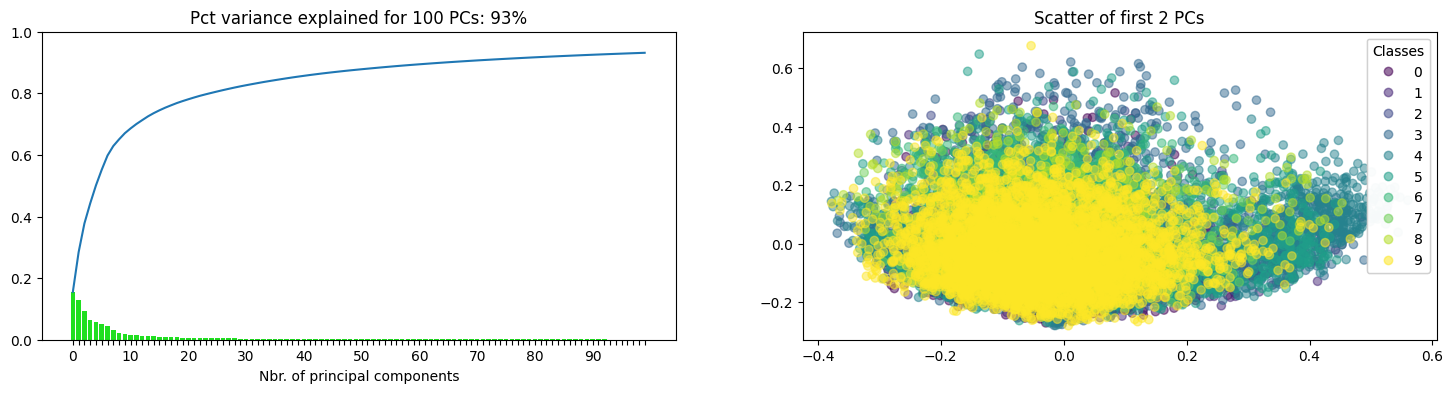

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# variance ratio % per PC
bar = sns.barplot(x=np.arange(100), y=pca.explained_variance_ratio_, color='lime', ax=ax[0])
for ind, label in enumerate(bar.get_xticklabels()):
  if ind % 10 == 0:  # every 10th label is kept
      label.set_visible(True)
  else:
      label.set_visible(False)
sns.lineplot(x=np.arange(100), y=np.cumsum(pca.explained_variance_ratio_), ax=ax[0])
ax[0].set_title(f'Pct variance explained for {nc} PCs: {pca.explained_variance_ratio_.sum():.0%}')
ax[0].set_xlabel('Nbr. of principal components')
ax[0].set_ylim([0, 1.])
# ax.grid()

# scatter of 2 PCs
scatter = ax[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, alpha=0.5)
legend1 = ax[1].legend(*scatter.legend_elements(), title="Classes")
ax[1].add_artist(legend1)
ax[1].set_title('Scatter of first 2 PCs')

plt.show()